In [1]:
import pandas as pd
import numpy as np
import os
import re
import io
import functools
import math
from sklearn.cluster import *
import matplotlib.pyplot as plt

In [6]:
def standardize(word):
    word = word.lower()
    return word
    
def create_dict(text_documents):
    dictionary = []
    for doc in text_documents:
        lines = doc.split("\n")
        for line in lines:
            words = re.split('[,.;:!? \t(){}]', line)
            for i, word in enumerate(words):
                if i >= w:
                    break
                word = standardize(word)
                if word == '':
                    continue
                if word not in dictionary:
                    dictionary.append(word)
    return dictionary

def text_features_extractor(text):
    features = dict(zip(dictionary, np.zeros(len(dictionary), dtype='int')))
    keys = features.keys()
    lines = text.split("\n")
    for line in lines:
        words = re.split('[,.;:!? \t]', line)
        for i, word in enumerate(words):
            if i >= w:
                    break
            word = standardize(word)
            if word in keys:
                features[word] += 1
    return list(features.values())

In [7]:
k = 2
l = math.ceil(math.log(k, 2))

w = 500

low = 0.01
high = 0.10

In [18]:
dataset = 'Articles.csv'
data = pd.read_csv(dataset)
data1 = data.iloc[:500,:]
data2 = data.iloc[1800:2300,:]
data = pd.concat([data1, data2])
dictionary = create_dict(data['Article'])
labels = data['NewsType']
labels_head = np.unique(labels.to_numpy())
num_labels = len(labels_head)
num_articles = 1000

In [22]:
len(dictionary)
#dictionary

21053

In [24]:
#kaggle
A = data['Article'].apply(lambda row: text_features_extractor(row)).values.tolist()
A = np.transpose(A)
# print(A)

In [25]:
A = np.array(A)
print(A.shape)

(21053, 1000)


In [26]:
# filtracija A, izbacivanje rijetkih i cestih rijeci
df = pd.DataFrame(A)
df2 = df.applymap(lambda x: 1 if x != 0 else 0)
counts = list(df2.apply(lambda x: sum(x) / len(labels), axis=1))
selected = [low < count < high for count in counts]
df['words'] = dictionary
df = df.loc[selected, :]
wordsmap = df['words']
wordsmap = wordsmap.reset_index()
df = df.drop(['words'], axis = 1)
A = df.to_numpy()
#print(A)

In [27]:
print(A.shape)

(2334, 1000)


In [28]:
D1_diag = np.sum(A, axis=1)
D1 = np.diag(D1_diag)

In [29]:
D2_diag = np.sum(A, axis=0)
D2 = np.diag(D2_diag)

In [30]:
D1_inv = np.diag(list(map(lambda x: 0 if x == 0 else 1/(np.sqrt(x)), D1_diag)))
D2_inv = np.diag(list(map(lambda x: 0 if x == 0 else 1/(np.sqrt(x)), D2_diag)))

In [31]:
An = D1_inv @ A @ D2_inv

In [32]:
u, s, vt = np.linalg.svd(An)
v = np.transpose(vt)

In [33]:
U = u[:, 1:(1+l)]
V = v[:, 1:(1+l)]
print(U.shape)
print(V.shape)

(2334, 1)
(1000, 1)


In [34]:
Z = np.block([[D1_inv @ U], [D2_inv @ V]])
# Z = Z.tolist()
# Z = list(map(lambda t: t[0], Z))
# # print(Z)
# Z = np.array(Z).reshape(-1, 1)

In [35]:
kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
kmeans.fit(Z)
predictions = kmeans.predict(Z)

In [36]:
table = np.zeros((k, num_labels), dtype='int')
table = pd.DataFrame(table, columns=labels_head)


for i, pred in enumerate(predictions[-num_articles:]):
    label = labels.iloc[i]
#     print("{}-{}".format(pred, label))
    table[label][pred] += 1
print(table)

   business  sports
0         5     496
1       495       4


In [37]:
predictions_words = predictions[0:-num_articles]
predictions_docs = predictions[-num_articles:]

In [38]:
for i in range(k):
    print('klaster {}'.format(i))
    selected = predictions_docs == i
    B = pd.DataFrame(A)
    B=B.iloc[:, selected]
    B['weight'] = B.sum(axis = 1, skipna = True)
    B_sorted = B.sort_values(by='weight', ascending=False)
    print(wordsmap.iloc[B_sorted.index[0:10]])

klaster 0
      index    words
1873   7662     amir
1730   5630      sri
1714   5422      her
1731   5631    lanka
1711   5395     tour
2053  11459  wickets
561    1135      she
1257   2953     goal
1174   2663      cup
2194  12331   lord´s
klaster 1
      index    words
134     276      yen
880    1803      tax
485     968  barrels
677    1335    power
35       81  trading
438     872       rs
1477   3786        s
107     215    index
436     869    rates
37       85  chinese


In [29]:
B = pd.DataFrame(A)
B=B.drop(B.columns[predictions_docs==0], axis = 1)
B['weight'] = B.sum(axis = 1, skipna = True)
B_sorted = B.sort_values(by='weight', ascending=False)
wordsmap.iloc[B_sorted.index[0:10]]

,index,words
210,1271,his
154,691,he
56,234,is
54,226,from
42,192,after
8,29,will
1,4,has
96,383,but
60,254,""""
88,346,first


In [30]:
predictions_words

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [31]:
predictions_docs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

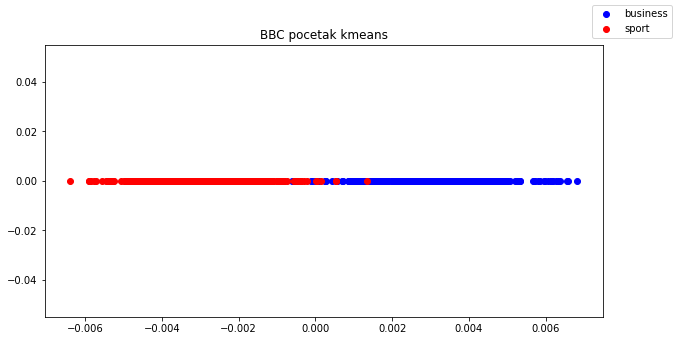

In [68]:
fig = plt.figure(figsize=(10, 5))
plt.title("BBC pocetak kmeans")
labels2 = labels.to_numpy()
first = labels2[labels2=='business']
plt.scatter(Z[-num_articles:-num_articles+len(first)], np.zeros(len(first)), color='blue')
plt.scatter(Z[-num_articles+len(first):], np.zeros(num_articles-len(first)), color='red')
fig.legend(['business', 'sport'])
# if len(pred_false) > 0:
#     plt.scatter(pred_false[:,0], pred_false[:, 1], color='red')
plt.savefig('BBC.png')
plt.show()

In [ ]:
plt.figure(figsize=(30, 15))
plt.title("BBC particije")
labels2 = predictions_docs.to_numpy()
first = predictions_docs[predictions_docs==1]
plt.scatter(Z[-num_articles:-num_articles+len(first)], np.zeros(len(first)), color='blue')
plt.scatter(Z[-num_articles+len(first):], np.zeros(num_articles-len(first)), color='red')
# if len(pred_false) > 0:
#     plt.scatter(pred_false[:,0], pred_false[:, 1], color='red')
plt.savefig( '/' + 'activations - predicted.png')
plt.show()

In [60]:
labels2

array(['business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'business',
       'business', 'business', 'business', 'business', 'busine

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

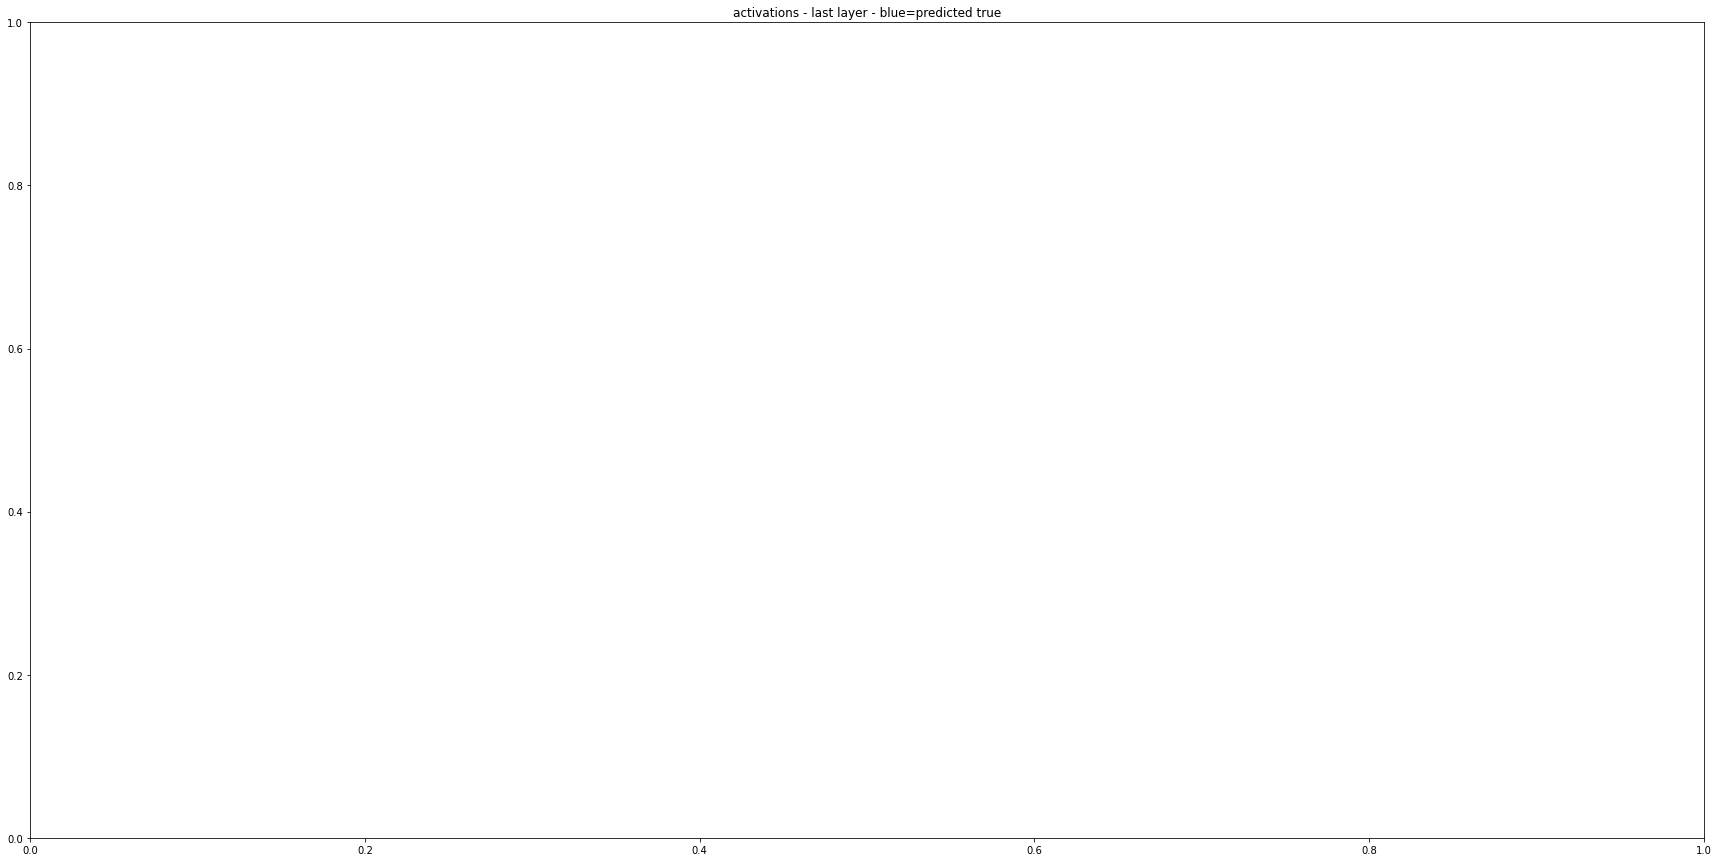

In [53]:

import matplotlib.cm as cm
cmap = cm.get_cmap(name='rainbow')

plt.figure(figsize=(30, 15))
plt.title("activations - last layer - blue=predicted true")
first = labels[labels==1]
plt.scatter(Z[-num_articles:], np.zeros(num_articles), colors=cmap(labels))
# if len(pred_false) > 0:
#     plt.scatter(pred_false[:,0], pred_false[:, 1], color='red')
# plt.savefig(folder + '/' + 'activations - predicted.png')
plt.show()